In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from unet.unet_helpers import *
from unet.unet import UNet
from unet.utils import visualize_sample

In [2]:
labels = [0,1]
label_thresh = [10]
mask_label_info = [labels, label_thresh]
rescale_to = (128,128)
split_samples = None
bottom = './images/etching/all/bottom/'
top = './images/etching/all/top/'
mask = './images/etching/all/masks/'
# Original images
transformations = transforms.Compose([Rescale(rescale_to), ToTensor()])
etching_dataset = MicroscopeImageDataset(img_dir=[bottom, top], 
                                         mask_dir=mask,
                                         mask_label_info=mask_label_info, read_top=False,
                                         transf=transformations, split_samples=split_samples)

# Contrast, brightness adjusted
transformations = transforms.Compose([Rescale(rescale_to), 
                                      BrightnessContrastAdjustment((-0.3,1.3), 'brightness'), 
                                      ToTensor()])
etching_dataset_bc = MicroscopeImageDataset(img_dir=[bottom, top], 
                                         mask_dir=mask,
                                         mask_label_info=mask_label_info, read_top=False,
                                         transf=transformations, split_samples=split_samples)

# Rotated by 90 degrees
transformations = transforms.Compose([Rescale(rescale_to), 
                                      Rotate(90), 
                                      ToTensor()])
etching_dataset_rotate = MicroscopeImageDataset(img_dir=[bottom, top], 
                                         mask_dir=mask,
                                         mask_label_info=mask_label_info, read_top=False,
                                         transf=transformations, split_samples=split_samples)

combined_dset = ConcatDatasets(etching_dataset, etching_dataset_bc, etching_dataset_rotate)

In [3]:
combined_dset.top()

Top pictures not available. Initialize with 'read_top = True'
Top pictures not available. Initialize with 'read_top = True'
Top pictures not available. Initialize with 'read_top = True'


In [14]:
# U-Net definition
input_shape = list(combined_dset[0]['image'].shape)
print(input_shape)
depth = 3
n_filters = 2

model = UNet(input_shape, n_classes=len(labels), depth=depth, wf=n_filters, padding=2, kernel_size=5, up_mode='upconv', batch_norm=True, name='test')
model.summary()

[1, 128, 128]
 
U-Net 'test'
Depth               Layer               Input shape         Output shape        Trainable params    
0                   ConvBlock           [1, 128, 128]       [4, 128, 128]       524
0                   maxpool_2           [4, 128, 128]       [4, 64, 64]         0

1                   ConvBlock           [4, 64, 64]         [8, 64, 64]         2448
1                   maxpool_2           [8, 64, 64]         [8, 32, 32]         0

2                   ConvBlock           [8, 32, 32]         [16, 32, 32]        9696

1                   ConvTransposeLayer  [16, 32, 32]        [8, 64, 64]         520
1                   ConvLayer           [8, 64, 64]         [8, 64, 64]         4848

0                   ConvTransposeLayer  [8, 64, 64]         [4, 128, 128]       132
0                   ConvLayer           [4, 128, 128]       [4, 128, 128]       1224

0                   Output: Conv2d      [4, 128, 128]       [2, 128, 128]       10

-------------------------

C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [15]:
# Train parameter
batch_size = 5
epochs = 25
eta = 3e-2/batch_size
lambda_l2 = 1e-3
gamma = 0.7

# U-Net definition
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
criterion = torch.nn.CrossEntropyLoss()
dataloader = DataLoader(combined_dset, batch_size=batch_size,
                        shuffle=True, num_workers=4)

avg_epoch_loss, model = train_unet(model, device, optim, criterion, dataloader, 
                                   epochs=epochs, lambda_=1e-3, reg_type=None, 
                                   save=False)


Epoch 0
CrossEntropyLoss: 0.711
Epoch 1
CrossEntropyLoss: 0.664
Epoch 2
CrossEntropyLoss: 0.630
Epoch 3
CrossEntropyLoss: 0.599
Epoch 4
CrossEntropyLoss: 0.569
Epoch 5
CrossEntropyLoss: 0.539
Epoch 6
CrossEntropyLoss: 0.511
Epoch 7
CrossEntropyLoss: 0.468
Epoch 8
CrossEntropyLoss: 0.496
Epoch 9
CrossEntropyLoss: 0.420
Epoch 10
CrossEntropyLoss: 0.397
Epoch 11
CrossEntropyLoss: 0.378
Epoch 12
CrossEntropyLoss: 0.350
Epoch 13
CrossEntropyLoss: 0.309
Epoch 14
CrossEntropyLoss: 0.303
Epoch 15
CrossEntropyLoss: 0.287
Epoch 16
CrossEntropyLoss: 0.243
Epoch 17
CrossEntropyLoss: 0.247
Epoch 18
CrossEntropyLoss: 0.212
Epoch 19
CrossEntropyLoss: 0.200
Epoch 20
CrossEntropyLoss: 0.255
Epoch 21
CrossEntropyLoss: 0.213
Epoch 22
CrossEntropyLoss: 0.172
Epoch 23
CrossEntropyLoss: 0.165
Epoch 24
CrossEntropyLoss: 0.159


Text(0, 0.5, 'CrossEntropyLoss')

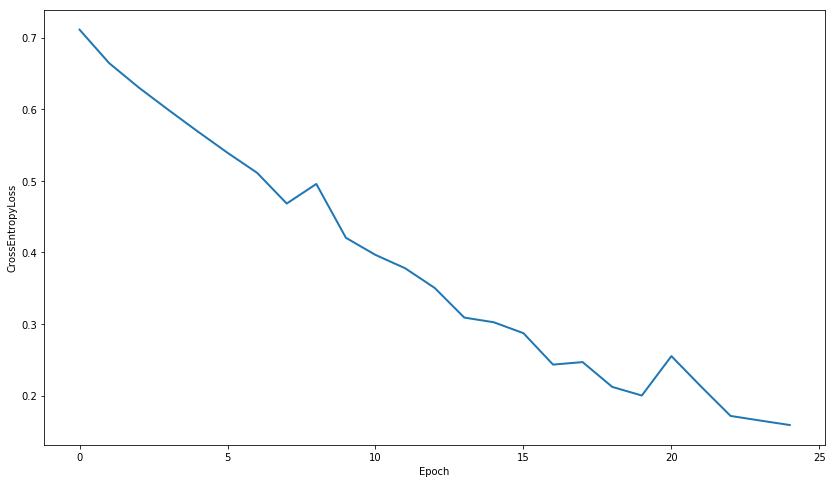

In [16]:
# Visualize
import numpy as np
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(np.arange(epochs), np.array(avg_epoch_loss), linewidth=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("CrossEntropyLoss")

C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


torch.Size([1, 128, 128])


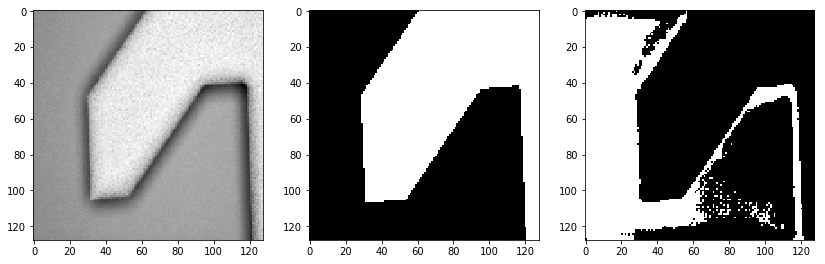

In [25]:
# Infere a sample
fig = plt.figure(figsize=(14,8))
i = 27
sample, infered_mask = combined_dset.infer(i, model)
axes = visualize_sample(fig, sample, infered_mask)


Infere on test dataset

In [8]:
transformations = transforms.Compose([Rescale((256,256)), ToTensor()])
test_dataset = MicroscopeImageDataset(img_dir=['./images/etching/test/bottom/','./images/etching/test/top/'], 
                                         mask_dir=None,
                                         mask_label_info=mask_label_info, read_top=True,
                                         transf=transformations, split_samples=split_samples)

In [9]:
test_dataset.bottom()

C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\silus\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


torch.Size([1, 256, 256])


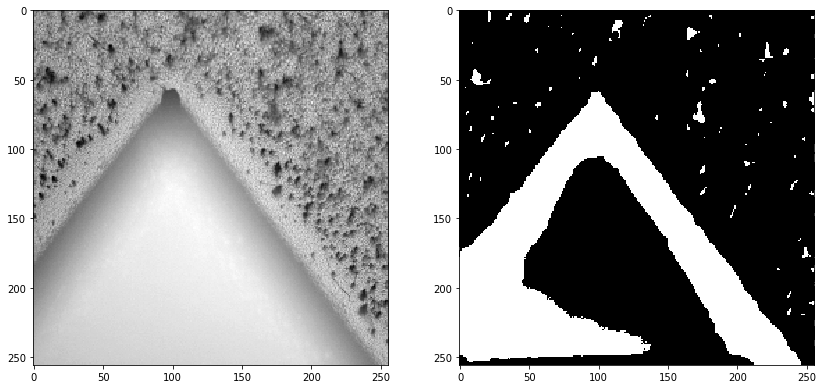

In [10]:
fig = plt.figure(figsize=(14,8))
i = 2
sample, infered_mask = test_dataset.infer(i, model)
axes = visualize_sample(fig, sample, infered_mask)
plt.show()